In [165]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn import metrics

import phik #https://towardsdatascience.com/phik-k-get-familiar-with-the-latest-correlation-coefficient-9ba0032b37e7

# Домашнее задание
Где дешевле жить? Предсказание цен в Airbnb - учимся генерировать признаки и интерпретировать результаты модели

Цель:
В этом проекте вы потренируетесь строить интерпретируемые модели линейной регрессии с регуляризацией и без, а также придумывать новые признаки для улучшения качества модели.

## Часть 1. EDA

### 1.1 Скачайте данные с Kaggle по ценам на жильё в Airbnb в Нью-Йорке:
https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data

In [166]:
data = pd.read_csv('AB_NYC_2019.csv')

In [167]:
df = data.copy() #скопирую data в переменую df, чтобы не подгружать data

In [168]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


#### Вывод: Скачал данные с Kaggle по ценам на жильё в Airbnb в Нью-Йорке

###  1.2 Пройдите по основным шагам работы с данными - базовые статистики, визуализации (распределения, корреляции, pair plots), предобработка переменных. Переменные, которые пока нужно убрать: id, name, host_id, host_name, last_review.

#### 1.2.1 базовые статистики

In [169]:
df.shape

(48895, 16)

In [170]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [171]:
# колонки на удаление Переменные, которые пока нужно убрать: id, name, host_id, host_name, last_review
drop_list = ['id', 'name', 'host_id', 'host_name', 'last_review']

In [172]:
# базовые статистики
df.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.889500e+04,4.889500e+04,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,1.901714e+07,6.762001e+07,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,1.098311e+07,7.861097e+07,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.471945e+06,7.822033e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,1.967728e+07,3.079382e+07,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,2.915218e+07,1.074344e+08,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


In [173]:
#незаполненные значения в данных
df.isnull().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

##### незаполненные данные есть только в столбце reviews_per_month - количество отзывов в месяц. last_review name host_name in drop_list

In [174]:
# заменю нулями пустые значения
df['reviews_per_month'] = df['reviews_per_month'].fillna(0)

In [175]:
#незаполненные значения в данных после замены
df.isnull().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                     0
calculated_host_listings_count        0
availability_365                      0
dtype: int64

##### незаполненные данных нет

#### выделим колонки по типам данных

In [176]:
df.dtypes.value_counts()

int64      7
object     6
float64    3
dtype: int64

In [177]:
#числовые, непрерывные переменныe
columns = df.drop(columns = drop_list).select_dtypes(['int64', 'float64']).columns
print(columns)

Index(['latitude', 'longitude', 'price', 'minimum_nights', 'number_of_reviews',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')


In [178]:
#категориальные переменные
categorical_columns = df.drop(columns = drop_list).select_dtypes(['object']).columns
print(categorical_columns)

Index(['neighbourhood_group', 'neighbourhood', 'room_type'], dtype='object')


####  1.2.2 визуализации (распределения, корреляции, pair plots), предобработка переменных

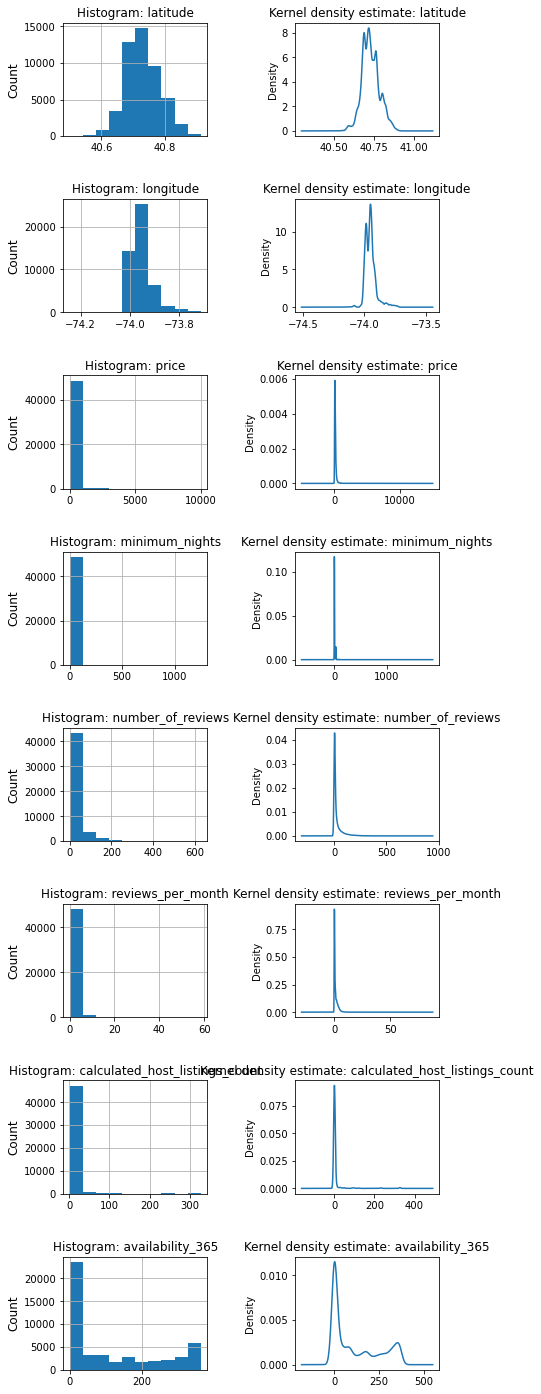

In [179]:
# гистограммы и графики плотности распределения признаков для числовых, непрерывных переменных
# окружение для графиков, для каждой колонки два столбца
fig, axs = plt.subplots(nrows=len(columns), ncols=2, figsize=(7,20))

for index, column in enumerate(columns):
    # В первом столбце гистограмма
    df[column].hist(ax=axs[index, 0])
    axs[index, 0].set_title(f'Histogram: {column}', fontsize=12)
    axs[index, 0].set_ylabel('Count', fontsize=12)
        
    # Во втором столбце график сглаженной плотности распределения на основе ядерной оценки
    df[column].plot(kind='kde', ax=axs[index, 1])
    axs[index, 1].set_title(f'Kernel density estimate: {column}', fontsize=12)

plt.tight_layout(pad=3.0)
plt.show()

<AxesSubplot:>

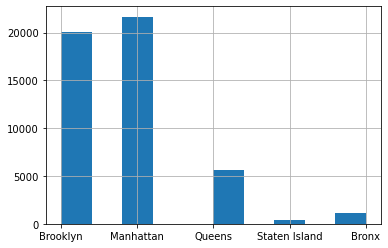

In [180]:
#категориальные переменныe
df['neighbourhood_group'].hist()

<AxesSubplot:>

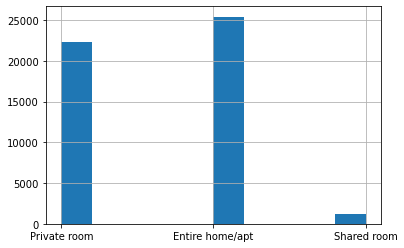

In [181]:
df['room_type'].hist()

<AxesSubplot:>

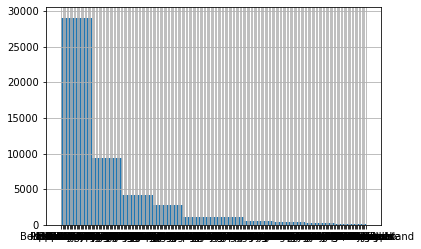

In [182]:
df['neighbourhood'].hist()

##### переведу neighbourhood_group и room_type в переменные-индикаторы, а для переменной neighbourhood применю частотное кодирование.

In [183]:
#neighbourhood_group и room_type в переменные-индикаторы
df = pd.concat([df, pd.get_dummies(df['neighbourhood_group']), pd.get_dummies(df['room_type'])], axis=1)

In [184]:
#neighbourhood применю частотное кодирование
df_neighbourhood_freq = pd.DataFrame(df['neighbourhood'].value_counts(normalize=True)).reset_index().rename(columns={'neighbourhood': 'neighbourhood_freq'})
df = df.merge(df_neighbourhood_freq, how = 'left', left_on='neighbourhood', right_on = 'index')
df.drop(columns='index', inplace=True)

In [185]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,...,availability_365,Bronx,Brooklyn,Manhattan,Queens,Staten Island,Entire home/apt,Private room,Shared room,neighbourhood_freq
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,...,365,0,1,0,0,0,0,1,0,0.003579
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,...,355,0,0,1,0,0,1,0,0,0.031598
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,...,365,0,0,1,0,0,0,1,0,0.054361
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,...,194,0,1,0,0,0,1,0,0,0.011699
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,...,0,0,0,1,0,0,1,0,0,0.022845


In [186]:
# посмотрю, какие столбцы есть и какие на удаление, при необоходимости дополню список drop_list
print(f'df.columns: {df.columns}')
print(f'drop_list: {drop_list}')

df.columns: Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'Bronx', 'Brooklyn', 'Manhattan', 'Queens',
       'Staten Island', 'Entire home/apt', 'Private room', 'Shared room',
       'neighbourhood_freq'],
      dtype='object')
drop_list: ['id', 'name', 'host_id', 'host_name', 'last_review']


In [187]:
#дополнение drop_list
drop_list.extend(['neighbourhood_group', 'neighbourhood', 'room_type'])

In [188]:
drop_list

['id',
 'name',
 'host_id',
 'host_name',
 'last_review',
 'neighbourhood_group',
 'neighbourhood',
 'room_type']

In [189]:
df.drop(drop_list, axis=1, inplace=True)

In [190]:
df.columns

Index(['latitude', 'longitude', 'price', 'minimum_nights', 'number_of_reviews',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'Bronx', 'Brooklyn', 'Manhattan', 'Queens',
       'Staten Island', 'Entire home/apt', 'Private room', 'Shared room',
       'neighbourhood_freq'],
      dtype='object')

In [191]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48895 entries, 0 to 48894
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   latitude                        48895 non-null  float64
 1   longitude                       48895 non-null  float64
 2   price                           48895 non-null  int64  
 3   minimum_nights                  48895 non-null  int64  
 4   number_of_reviews               48895 non-null  int64  
 5   reviews_per_month               48895 non-null  float64
 6   calculated_host_listings_count  48895 non-null  int64  
 7   availability_365                48895 non-null  int64  
 8   Bronx                           48895 non-null  uint8  
 9   Brooklyn                        48895 non-null  uint8  
 10  Manhattan                       48895 non-null  uint8  
 11  Queens                          48895 non-null  uint8  
 12  Staten Island                   

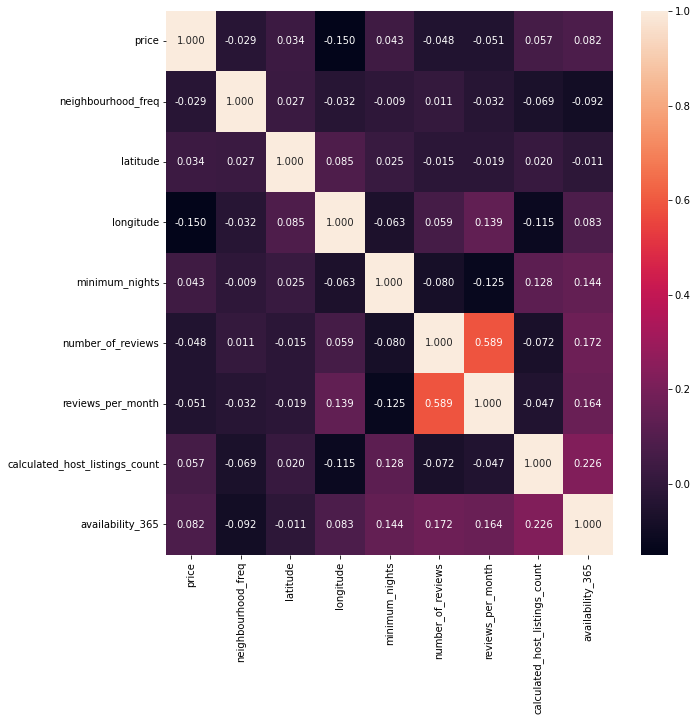

In [192]:
#корреляции
corr_list = ['price', 'neighbourhood_freq', 'latitude', 'longitude', 'minimum_nights', 
           'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']
corr = df[corr_list].corr()

# Отобразим ее на тепловой карте
plt.figure(figsize=(10,10));
sns.heatmap(corr, annot=True, fmt='.3f');

In [193]:
phik_overview = df[corr_list].phik_matrix(interval_cols=corr_list)

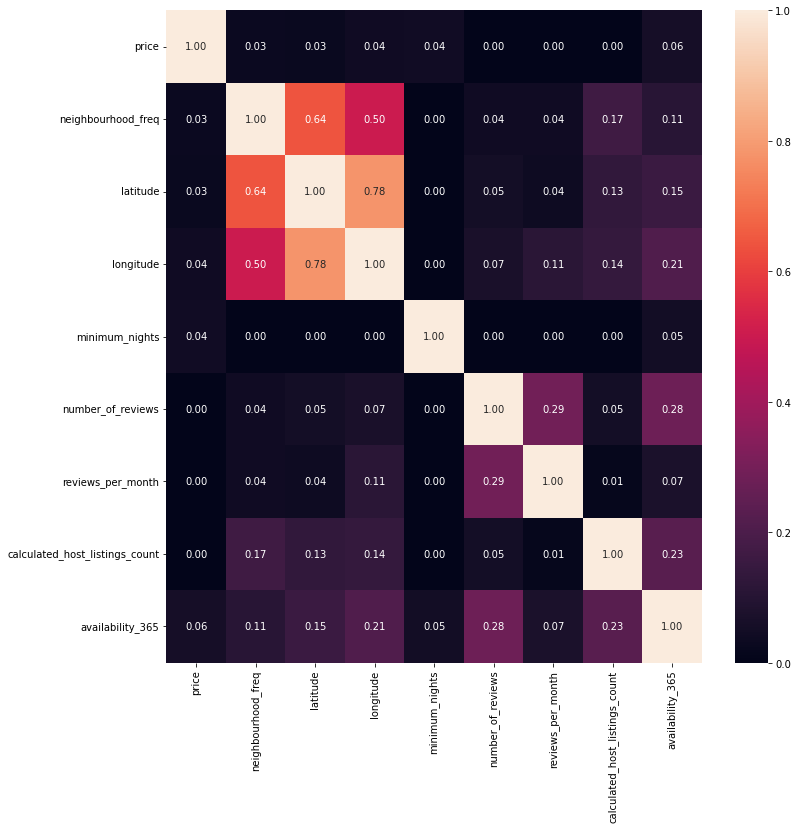

In [194]:
plt.figure(figsize=(12,12));
sns.heatmap(phik_overview, annot=True, fmt='.2f');

In [195]:
#Как видно из графика корреляции, зависимыми друг от друга являются 
#number_of_reviews', 'reviews_per_month;  neighbourhood_freq и ('latitude' or 'longitude')
#Построим графики парных корреляций, действительно ли между признаками наблюдается линейная зависимость.

<AxesSubplot:xlabel='reviews_per_month', ylabel='number_of_reviews'>

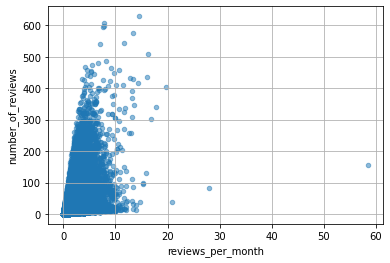

In [196]:
df[['reviews_per_month', 'number_of_reviews']].plot(kind = 'scatter', y='number_of_reviews', x='reviews_per_month', 
                                                    grid = True, alpha = 0.5)

<AxesSubplot:xlabel='latitude', ylabel='neighbourhood_freq'>

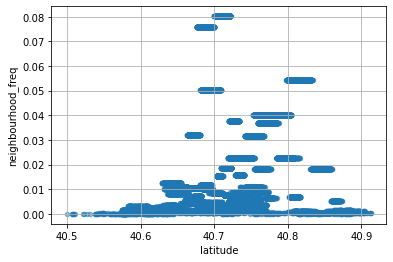

In [197]:
df[['neighbourhood_freq', 'latitude']].plot(kind = 'scatter', y='neighbourhood_freq', x='latitude', 
                                                    grid = True, alpha = 0.5)

<AxesSubplot:xlabel='longitude', ylabel='neighbourhood_freq'>

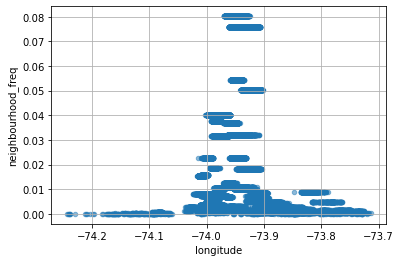

In [198]:
df[['neighbourhood_freq', 'longitude']].plot(kind = 'scatter', y='neighbourhood_freq', x='longitude', 
                                                    grid = True, alpha = 0.5)

## Части 2,3. Preprocessing & Feature Engineering. Моделирование
### Preprocessing & Feature Engineering
Ваша цель получить как можно более высокие метрики качества (можно взять несколько, R2, MAE, RMSE), сконцентрировавшись на преобразовании признаков.
Опробуйте различные техники:
работа с категориальными переменными (можно начать с dummy);
замена аномалий;
различные варианты шкалирования непрерывных переменных (StandardScaler, RobustScaler, и.т.д.);
обратите внимание на распределение целевой переменной, возможно, с ней тоже можно поработать;
Попробуйте на основании имеющихся переменных создать новые, которые могли бы улучшить качество модели. Например, можно найти координаты Манхэттена (самого дорогого района) и при помощи широты и долготы, а также евклидового расстояния создать новую переменную - расстояние от квартиры до этого района. Возможно, такой признак будет работать лучше, чем просто широта и долгота.
### Моделирование
Отложите 30% данных для тестирования.
Постройте модели простой линейной регрессии, RidgeCV, LassoCV и ElasticNetCV.
Измерьте качество каждой и визуализируйте важность признаков.
Сделайте интересные выводы :)

In [199]:
#зафиксирую random_state
random_state=13

In [200]:
# Сохраню в  𝑋 все колонки признаки, а в  𝑦−целевую переменную.
X = df.drop('price', axis=1)
y = df['price']

X.shape, y.shape

((48895, 16), (48895,))

In [201]:
# Разобью данные на тренировочный и тестовый наборы.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)

In [202]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((34226, 16), (14669, 16), (34226,), (14669,))

In [203]:
# метрики качества буду собирать в дата-фрейм df_metrics. Создам функцию
def get_df_metrics():
    df_metrics = pd.DataFrame({"error_name":["MAE", "RMSE", "R2"]})
    df_metrics.set_index("error_name")
    return df_metrics

In [204]:
# Построение моделей линейной регрессии
def regression(X_train, X_test, y_train, y_test, regressor, regressor_name, df_metrics, plot_graphics=True):
    print('Регрессор:', regressor_name)
    
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)

    if (hasattr(regressor, 'alpha_')):
        print('Лучшее значение параметра регуляризации: {:.5f}'.format(regressor.alpha_))

    df_metrics[regressor_name] = [
       metrics.mean_absolute_error(y_test, y_pred),
       np.sqrt(metrics.mean_squared_error(y_test, y_pred)),
       metrics.r2_score(y_test, y_pred)       
    ]

    if (plot_graphics):
        featureImportance = pd.DataFrame({"feature": X_train.columns[regressor.coef_!=0], 
                                          "importance": regressor.coef_[regressor.coef_!=0]})

        featureImportance.set_index('feature', inplace=True)
        featureImportance.sort_values(["importance"], ascending=False, inplace=True)

        featureImportance["importance"].plot(kind='bar', figsize=(10, 5));    
        plt.title("Feature Importance - " + regressor_name)
        plt.xlabel("Feature")
        plt.ylabel("Importance")
        plt.show()

Регрессор: LinearRegression


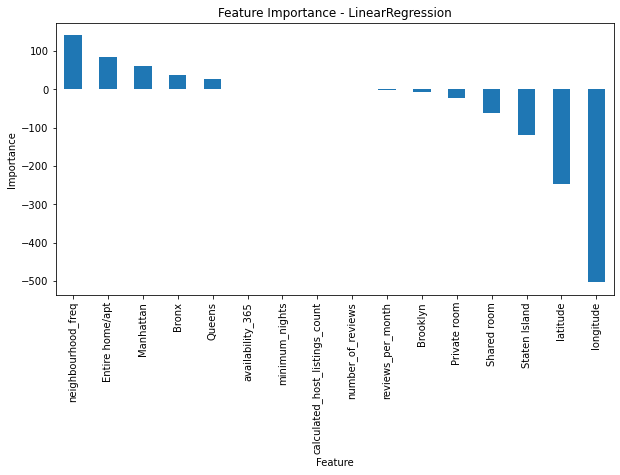

,error_name,LinearRegression
0,MAE,73.186321
1,RMSE,227.860225
2,R2,0.091477


In [205]:
# Построю простую модель регрессии
df_metrics = get_df_metrics()

regression(X_train, X_test, y_train, y_test, LinearRegression(), 'LinearRegression', df_metrics)

df_metrics

Регрессор: RidgeCV
Лучшее значение параметра регуляризации: 1.00000


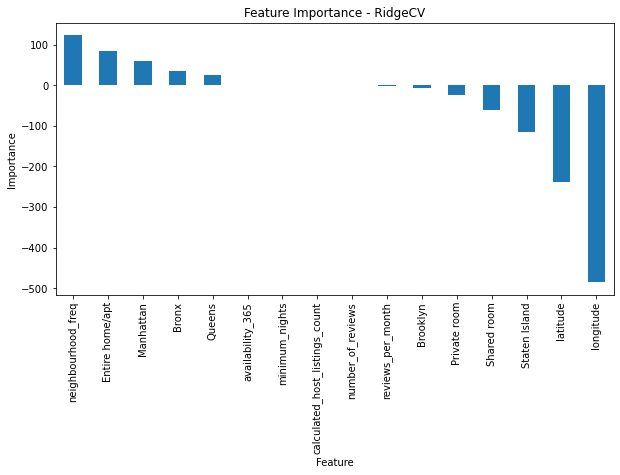

,error_name,LinearRegression,RidgeCV
0,MAE,73.186321,73.159855
1,RMSE,227.860225,227.864648
2,R2,0.091477,0.091441


In [206]:
# Построю модель регрессии RidgeCV
regression(X_train, X_test, y_train, y_test, RidgeCV(cv=5), 'RidgeCV', df_metrics)

df_metrics

Регрессор: LassoCV
Лучшее значение параметра регуляризации: 2.74310


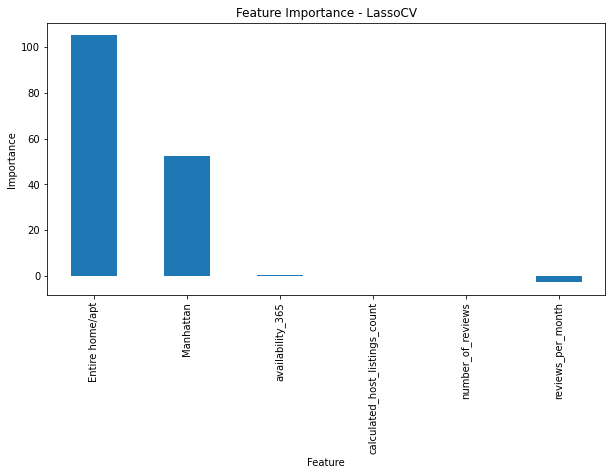

,error_name,LinearRegression,RidgeCV,LassoCV
0,MAE,73.186321,73.159855,73.064345
1,RMSE,227.860225,227.864648,228.711975
2,R2,0.091477,0.091441,0.084672


In [207]:
# Построение модели регрессии LassoCV
regression(X_train, X_test, y_train, y_test, LassoCV(), 'LassoCV', df_metrics)

df_metrics

Регрессор: ElasticNetCV
Лучшее значение параметра регуляризации: 5.48621


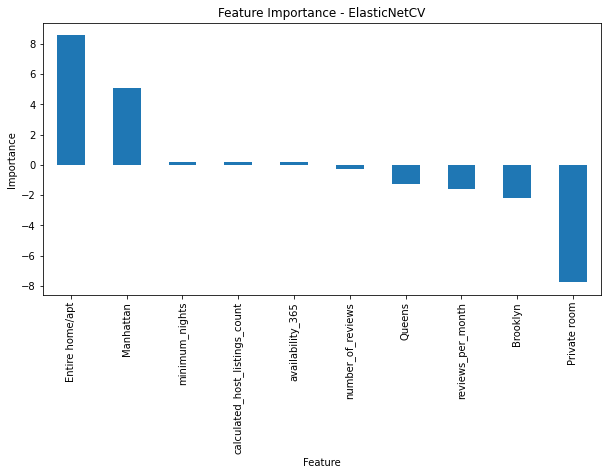

,error_name,LinearRegression,RidgeCV,LassoCV,ElasticNetCV
0,MAE,73.186321,73.159855,73.064345,86.089001
1,RMSE,227.860225,227.864648,228.711975,235.576292
2,R2,0.091477,0.091441,0.084672,0.028904


In [208]:
# Построение модели регрессии ElasticNetCV
regression(X_train, X_test, y_train, y_test, ElasticNetCV(cv=5), 'ElasticNetCV', df_metrics)

df_metrics

In [209]:
# все регрессоры и пересчитывать метрики
def all_regressions(X_train, X_test, y_train, y_test):
    df_metrics = get_df_metrics()
    
    regression(X_train, X_test, y_train, y_test, LinearRegression(), 'LinearRegression', df_metrics, False)
    regression(X_train, X_test, y_train, y_test, RidgeCV(cv=5), 'RidgeCV', df_metrics, False)
    regression(X_train, X_test, y_train, y_test, LassoCV(cv=5), 'LassoCV', df_metrics, False)
    regression(X_train, X_test, y_train, y_test, ElasticNetCV(cv=5), 'ElasticNetCV', df_metrics, False)
    
    return df_metrics

In [210]:
df_metrics = all_regressions(X_train, X_test, y_train, y_test)
df_metrics_base = df_metrics.copy()
df_metrics_base

Регрессор: LinearRegression
Регрессор: RidgeCV
Лучшее значение параметра регуляризации: 1.00000
Регрессор: LassoCV
Лучшее значение параметра регуляризации: 2.74310
Регрессор: ElasticNetCV
Лучшее значение параметра регуляризации: 5.48621


,error_name,LinearRegression,RidgeCV,LassoCV,ElasticNetCV
0,MAE,73.186321,73.159855,73.064345,86.089001
1,RMSE,227.860225,227.864648,228.711975,235.576292
2,R2,0.091477,0.091441,0.084672,0.028904


##### базовые метрики качества в переменной df_metrics_base. В среднем RidgeCV показала лучшие метрики качества

In [211]:
def regressions_with_scaler(data, scaler, to_scale):
    X = data.drop('price', axis=1)
    y = data['price']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)

    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()

    X_train_scaled[to_scale] = scaler.fit_transform(X_train[to_scale])
    X_test_scaled[to_scale] = scaler.transform(X_test[to_scale])

    return all_regressions(X_train_scaled, X_test_scaled, y_train, y_test)

In [212]:
scaler_list = ['neighbourhood_freq', 'latitude', 'longitude', 'minimum_nights', 
               'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']   

In [213]:
#прошкалирую данные с помощью StandardScaler   
df_metrics = regressions_with_scaler(df, StandardScaler(), scaler_list)
df_metrics_StandardScaler = df_metrics.copy()
df_metrics_StandardScaler

Регрессор: LinearRegression
Регрессор: RidgeCV
Лучшее значение параметра регуляризации: 10.00000
Регрессор: LassoCV
Лучшее значение параметра регуляризации: 0.03675
Регрессор: ElasticNetCV
Лучшее значение параметра регуляризации: 0.07350


,error_name,LinearRegression,RidgeCV,LassoCV,ElasticNetCV
0,MAE,73.236457,73.164194,73.142410,72.810911
1,RMSE,227.865581,227.862977,227.863207,228.170576
2,R2,0.091434,0.091455,0.091453,0.089000


In [214]:
# сравним с df_metrics_base
df_metrics_base

,error_name,LinearRegression,RidgeCV,LassoCV,ElasticNetCV
0,MAE,73.186321,73.159855,73.064345,86.089001
1,RMSE,227.860225,227.864648,228.711975,235.576292
2,R2,0.091477,0.091441,0.084672,0.028904


##### LassoCV, ElasticNetCV стало лучше, остальные улучшились, но не много

In [215]:
#прошкалирую данные с помощью RobustScaler
df_metrics = regressions_with_scaler(df, RobustScaler(), scaler_list)
df_metrics_RobustScaler = df_metrics.copy()
df_metrics_RobustScaler

Регрессор: LinearRegression
Регрессор: RidgeCV
Лучшее значение параметра регуляризации: 10.00000
Регрессор: LassoCV
Лучшее значение параметра регуляризации: 0.45660
Регрессор: ElasticNetCV
Лучшее значение параметра регуляризации: 0.91320


,error_name,LinearRegression,RidgeCV,LassoCV,ElasticNetCV
0,MAE,73.186321,73.161986,72.975800,75.264394
1,RMSE,227.860225,227.862721,228.044828,230.375945
2,R2,0.091477,0.091457,0.090004,0.071305


In [216]:
# сравним с df_metrics_base
df_metrics_base

,error_name,LinearRegression,RidgeCV,LassoCV,ElasticNetCV
0,MAE,73.186321,73.159855,73.064345,86.089001
1,RMSE,227.860225,227.864648,228.711975,235.576292
2,R2,0.091477,0.091441,0.084672,0.028904


##### df_metrics_base: LassoCV, ElasticNetCV стало лучше, остальные улучшились, но не много

In [217]:
# сравним с df_metrics_StandardScaler
df_metrics_StandardScaler

,error_name,LinearRegression,RidgeCV,LassoCV,ElasticNetCV
0,MAE,73.236457,73.164194,73.142410,72.810911
1,RMSE,227.865581,227.862977,227.863207,228.170576
2,R2,0.091434,0.091455,0.091453,0.089000


##### df_metrics_StandardScaler лучше чем df_metrics_RobustScaler

### новые переменные
1. расстояние до Манхэттена
2. создание переменной дистрикт и ее кодирование

In [218]:
df.head()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,Bronx,Brooklyn,Manhattan,Queens,Staten Island,Entire home/apt,Private room,Shared room,neighbourhood_freq
0,40.64749,-73.97237,149,1,9,0.21,6,365,0,1,0,0,0,0,1,0,0.003579
1,40.75362,-73.98377,225,1,45,0.38,2,355,0,0,1,0,0,1,0,0,0.031598
2,40.80902,-73.94190,150,3,0,0.00,1,365,0,0,1,0,0,0,1,0,0.054361
3,40.68514,-73.95976,89,1,270,4.64,1,194,0,1,0,0,0,1,0,0,0.011699
4,40.79851,-73.94399,80,10,9,0.10,1,0,0,0,1,0,0,1,0,0,0.022845


In [219]:
# новые переменные. расстояние до Манхэттена manhattan_coord = (40.758896, -73.985130)
# создаю столбцы df['lat0'] = 40.758896 df['lon0'] = -73.985130,  df['distance'] = sqrt((lat0 - latitude)^2 + (lon0 - longitude)^2)
# latitude, longitude, df['lat0'], df['lon0'] - drop
df['lat0'] = 40.758896
df['lon0'] = -73.985130
df['distance'] = ((df['lat0'] - df['latitude'])**2 + (df['lon0'] - df['longitude'])**2)**0.5
df.drop(columns = ['latitude', 'longitude', 'lat0', 'lon0'], inplace=True)
df.head()

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,Bronx,Brooklyn,Manhattan,Queens,Staten Island,Entire home/apt,Private room,Shared room,neighbourhood_freq,distance
0,149,1,9,0.21,6,365,0,1,0,0,0,0,1,0,0.003579,0.112134
1,225,1,45,0.38,2,355,0,0,1,0,0,1,0,0,0.031598,0.005448
2,150,3,0,0.00,1,365,0,0,1,0,0,0,1,0,0.054361,0.066191
3,89,1,270,4.64,1,194,0,1,0,0,0,1,0,0,0.011699,0.077997
4,80,10,9,0.10,1,0,0,0,1,0,0,1,0,0,0.022845,0.057112


<AxesSubplot:>

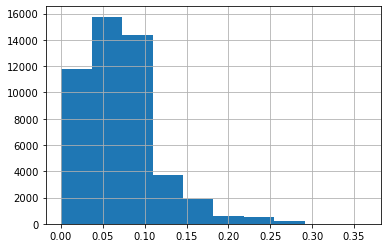

In [220]:
df['distance'].hist()

In [221]:
X = df.drop('price', axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)

In [222]:
scaler_list = ['neighbourhood_freq', 'distance', 'minimum_nights', 
               'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']   

In [223]:
df_metrics = regressions_with_scaler(df, StandardScaler(), scaler_list)
df_metrics

Регрессор: LinearRegression
Регрессор: RidgeCV
Лучшее значение параметра регуляризации: 10.00000
Регрессор: LassoCV
Лучшее значение параметра регуляризации: 0.04199
Регрессор: ElasticNetCV
Лучшее значение параметра регуляризации: 0.08397


,error_name,LinearRegression,RidgeCV,LassoCV,ElasticNetCV
0,MAE,72.815819,72.839607,72.790679,72.326167
1,RMSE,227.856946,227.860249,227.854288,227.909877
2,R2,0.091503,0.091476,0.091524,0.091081


In [224]:
df_metrics_base

,error_name,LinearRegression,RidgeCV,LassoCV,ElasticNetCV
0,MAE,73.186321,73.159855,73.064345,86.089001
1,RMSE,227.860225,227.864648,228.711975,235.576292
2,R2,0.091477,0.091441,0.084672,0.028904


In [225]:
df_metrics_StandardScaler

,error_name,LinearRegression,RidgeCV,LassoCV,ElasticNetCV
0,MAE,73.236457,73.164194,73.142410,72.810911
1,RMSE,227.865581,227.862977,227.863207,228.170576
2,R2,0.091434,0.091455,0.091453,0.089000


##### качество улучшилось

In [226]:
# новые переменные. districts = neighbourhood_group + neighbourhood -> pd.get_dummies
df['districts'] = data['neighbourhood_group'] + '.' + data['neighbourhood']

In [227]:
df.drop(columns=['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island'], inplace=True)

In [228]:
df.head()

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,Entire home/apt,Private room,Shared room,neighbourhood_freq,distance,districts
0,149,1,9,0.21,6,365,0,1,0,0.003579,0.112134,Brooklyn.Kensington
1,225,1,45,0.38,2,355,1,0,0,0.031598,0.005448,Manhattan.Midtown
2,150,3,0,0.00,1,365,0,1,0,0.054361,0.066191,Manhattan.Harlem
3,89,1,270,4.64,1,194,1,0,0,0.011699,0.077997,Brooklyn.Clinton Hill
4,80,10,9,0.10,1,0,1,0,0,0.022845,0.057112,Manhattan.East Harlem


In [229]:
df = pd.concat([df, pd.get_dummies(df['districts'])], axis=1)

In [230]:
df.drop(columns=['districts'], inplace=True)

In [231]:
X = df.drop('price', axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)

In [232]:
scaler_list = list(X.columns)

In [233]:
df_metrics = regressions_with_scaler(df, StandardScaler(), scaler_list)
df_metrics_best = df_metrics.copy()
df_metrics_best

Регрессор: LinearRegression
Регрессор: RidgeCV
Лучшее значение параметра регуляризации: 10.00000
Регрессор: LassoCV
Лучшее значение параметра регуляризации: 0.28791
Регрессор: ElasticNetCV
Лучшее значение параметра регуляризации: 0.18856


,error_name,LinearRegression,RidgeCV,LassoCV,ElasticNetCV
0,MAE,3.473094e+11,71.226183,70.660647,69.889609
1,RMSE,2.428616e+13,226.862938,226.767785,226.637858
2,R2,-1.032088e+22,0.099412,0.100167,0.101198


In [234]:
df_metrics_base

,error_name,LinearRegression,RidgeCV,LassoCV,ElasticNetCV
0,MAE,73.186321,73.159855,73.064345,86.089001
1,RMSE,227.860225,227.864648,228.711975,235.576292
2,R2,0.091477,0.091441,0.084672,0.028904


In [235]:
df_metrics_StandardScaler

,error_name,LinearRegression,RidgeCV,LassoCV,ElasticNetCV
0,MAE,73.236457,73.164194,73.142410,72.810911
1,RMSE,227.865581,227.862977,227.863207,228.170576
2,R2,0.091434,0.091455,0.091453,0.089000


# Вывод: лучшие метрики получились для модели df_metrics_best : ElasticNetCV